In [ ]:
!pip install torch transformers datasets numpy tqdm nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch

# Check if CUDA (GPU support) is available
print(torch.cuda.is_available())

# Get the name of the GPU (if available)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

False
No GPU found


# Transformer Class

In [ ]:
import torch.nn as nn
import math

# Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linear_Q = nn.Linear(d_model, d_model)
        self.linear_K = nn.Linear(d_model, d_model)
        self.linear_V = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention()

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.linear_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        attn_output = self.attention(Q, K, V, mask)
        concat = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linear_out(concat)


In [ ]:
# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

In [ ]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        return self.norm2(x + ff_output)

In [ ]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        self_attn_output = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self_attn_output)
        enc_dec_attn_output = self.enc_dec_attention(x, enc_output, enc_output, memory_mask)
        x = self.norm2(x + enc_dec_attn_output)
        ff_output = self.ff(x)
        return self.norm3(x + ff_output)

In [ ]:
# Transformer Model
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, device, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout).to(device) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout).to(device) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        seq_len_src = src.size(1)
        seq_len_tgt = tgt.size(1)
        src = self.encoder_embedding(src) + self.positional_encoding[:, :seq_len_src, :]
        tgt = self.decoder_embedding(tgt) + self.positional_encoding[:, :seq_len_tgt, :]

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, tgt_mask)

        return self.output_layer(tgt)

# Data Preprocessing

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Helsinki-NLP/opus-100", "en-id")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/132k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_data = dataset['train']
train_data = train_data.shuffle(seed=42).select(range(100000))

val_data = dataset['validation']
test_data = dataset['test']

print(train_data[:5])

{'translation': [{'en': '♪ Ch-ch-ch-ch-changes', 'id': '♪ Ch-ch-ch-ch-changes ♪'}, {'en': 'I know how to use this thing!', 'id': 'Aku tahu cara menggunakannya !'}, {'en': 'Chancellorship is a thankless job, Your Excellency.', 'id': 'Chancellorship adalah tugas yang dihargai, Yang Mulia.'}, {'en': "Great. That's awesome.", 'id': 'Itu mengagumkan.'}, {'en': 'Have you been by yourself all these years?', 'id': 'Kau pernah sendiri selama bertahun-tahun?'}]}


In [ ]:
train_source_texts = [example['en'] for example in train_data['translation']]
train_target_texts = [example['id'] for example in train_data['translation']]

val_source_texts = [example['en'] for example in val_data['translation']]
val_target_texts = [example['id'] for example in val_data['translation']]

test_source_texts = [example['en'] for example in test_data['translation']]
test_target_texts = [example['id'] for example in test_data['translation']]

print(train_source_texts[:5])
print(train_target_texts[:5])

['♪ Ch-ch-ch-ch-changes', 'I know how to use this thing!', 'Chancellorship is a thankless job, Your Excellency.', "Great. That's awesome.", 'Have you been by yourself all these years?']
['♪ Ch-ch-ch-ch-changes ♪', 'Aku tahu cara menggunakannya !', 'Chancellorship adalah tugas yang dihargai, Yang Mulia.', 'Itu mengagumkan.', 'Kau pernah sendiri selama bertahun-tahun?']


In [ ]:
# Add special tokens to your training data
train_target_texts = ["<SOS> " + text + " <EOS>" for text in train_target_texts]
val_target_texts = ["<SOS> " + text + " <EOS>" for text in val_target_texts]
test_target_texts = ["<SOS> " + text + " <EOS>" for text in test_target_texts]

print(train_target_texts[:5])

['<SOS> ♪ Ch-ch-ch-ch-changes ♪ <EOS>', '<SOS> Aku tahu cara menggunakannya ! <EOS>', '<SOS> Chancellorship adalah tugas yang dihargai, Yang Mulia. <EOS>', '<SOS> Itu mengagumkan. <EOS>', '<SOS> Kau pernah sendiri selama bertahun-tahun? <EOS>']


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Define maximum sequence lengths (modify as needed)
max_source_length = 60
max_target_length = 60

# Pad sequences to ensure uniform length
train_source_sequences = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

val_source_sequences = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

test_source_sequences = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')

In [ ]:
print(train_source_sequences[:2])
print(train_target_sequences[:2])

[[ 125 6859 6859 6859 6859 2013    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   3   32   61    4  321   13  148    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
[[    1   118  7876  7876  7876  7876 11756   118     2     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [    

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        if idx >= len(self.source_sequences):
            print(f"Index {idx} out of range for source_sequences with length {len(self.source_sequences)}")
            raise IndexError("Source sequence index out of range")

        if idx >= len(self.target_sequences):
            print(f"Index {idx} out of range for target_sequences with length {len(self.target_sequences)}")
            raise IndexError("Target sequence index out of range")

        source_seq = torch.tensor(self.source_sequences[idx], dtype=torch.long)
        target_seq = torch.tensor(self.target_sequences[idx], dtype=torch.long)
        return source_seq, target_seq

In [ ]:
assert len(train_source_sequences) == len(train_target_sequences), "Source and target sequences have different lengths!"
assert len(val_source_sequences) == len(val_target_sequences), "Source and target sequences have different lengths!"

for i, (src, tgt) in enumerate(zip(train_source_sequences, train_target_sequences)):
    if len(src) == 0 or len(tgt) == 0:
        print(f"Empty sequence found at index {i}: Source {src}, Target {tgt}")

In [ ]:
# Create dataset and dataloader
train_dataset = SequenceDataset(train_source_sequences, train_target_sequences)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SequenceDataset(val_source_sequences, val_target_sequences)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = SequenceDataset(test_source_sequences, test_target_sequences)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for source, target in train_dataloader:
    print("Source:", source)
    print("Target:", target)
    break

Source: tensor([[ 66,   0,   0,  ...,   0,   0,   0],
        [ 13,   9,   2,  ...,   0,   0,   0],
        [  1,  70, 399,  ...,   0,   0,   0],
        ...,
        [  3, 117,  39,  ...,   0,   0,   0],
        [ 27, 208, 165,  ...,   0,   0,   0],
        [163,  36, 185,  ...,   0,   0,   0]])
Target: tensor([[   1,   98,    2,  ...,    0,    0,    0],
        [   1,    9,  389,  ...,    0,    0,    0],
        [   1,   23,  151,  ...,    0,    0,    0],
        ...,
        [   1,    3,  105,  ...,    0,    0,    0],
        [   1,   12,   22,  ...,    0,    0,    0],
        [   1,  175, 1370,  ...,    0,    0,    0]])


# Model

In [ ]:
# Model Hyperparameters
vocab_size = max(source_vocab_size, target_vocab_size)
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6
max_seq_len = 60
dropout = 0.1
learning_rate = 5e-5
num_epochs = 10

In [ ]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, device, dropout)

model.to(device)
print(device)

cpu


In [ ]:
# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
path = "/content/drive/MyDrive/Kuliah/Semester 7/NLP/Transformer/"
checkpoint_path = path + "checkpoint/model_checkpoint.pth"
training_results = path + "results/training_results.csv"

In [ ]:
import os

# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, loss_history, val_loss_history, best_bleu_score=None):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss_history": loss_history,
        "val_loss_history": val_loss_history,
        "best_bleu_score": best_bleu_score,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}.")

# Function to load checkpoint
def load_checkpoint(model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        loss_history = checkpoint["loss_history"]
        val_loss_history = checkpoint["val_loss_history"]
        best_bleu_score = checkpoint.get("best_bleu_score", None)
        print(f"Resumed training from epoch {start_epoch}.")
        return start_epoch, loss_history, val_loss_history, best_bleu_score
    else:
        print("No checkpoint found. Starting fresh training.")
        return 0, [], [], None

In [ ]:
import csv
import pandas as pd

# Function to save a single epoch's losses to the CSV
def append_loss_to_csv(epoch, train_loss, val_loss, bleu_score,time_taken, csv_path=training_results):
    file_exists = os.path.exists(csv_path)
    with open(csv_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            # Write header if the file is being created for the first time
            writer.writerow(["Epoch", "Train Loss", "Val Loss", "Bleu Score", "Time Taken"])
        # Append the new epoch's losses
        writer.writerow([epoch, train_loss, val_loss, bleu_score, time_taken])
    print(f"Epoch {epoch + 1}:Val Loss: {val_loss:.4f} - Saved to {csv_path}.")

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to calculate BLEU score
def calculate_bleu(references, hypotheses):
    """
    Compute BLEU scores for a batch of references and hypotheses.
    `references`: List of lists of reference sentences (tokenized).
    `hypotheses`: List of hypothesis sentences (tokenized).
    """
    scores = []
    smoothing = SmoothingFunction().method4  # You can experiment with different smoothing methods

    for ref, hyp in zip(references, hypotheses):
        # BLEU score for each sentence with smoothing and using up to bigrams (unigram, bigram)
        score = sentence_bleu([ref], hyp, weights=(1.0, 0.0, 0.0, 0.0), smoothing_function=smoothing)
        scores.append(score)

    return sum(scores) / len(scores)  # Average BLEU score for the batch

#Training

In [ ]:
import time
from tqdm import tqdm

# Training loop
start_epoch, loss_history, val_loss_history, best_bleu_score = load_checkpoint(model, optimizer)

# List to store loss and BLEU scores
loss_history = []
val_loss_history = []
bleu_scores = []

# Initialize variables for checkpointing
best_bleu_score = 0.0
best_model_path = path + "best_model.pth"

for epoch in range(start_epoch, num_epochs):
    start = time.time()
    # Training
    model.train()
    total_train_loss = 0
    for src, tgt in tqdm(train_dataloader):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        outputs = model(src, tgt_input)  # Model output (logits)
        loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    references = []  # Store reference sentences for BLEU calculation
    hypotheses = []  # Store hypothesis sentences for BLEU calculation
    with torch.no_grad():
        for src, tgt in val_dataloader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            outputs = model(src, tgt_input)  # Shape: (batch_size, seq_len, vocab_size)
            loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
            total_val_loss += loss.item()

            # Collect predictions and references for BLEU
            predictions = outputs.argmax(dim=-1)  # Convert logits to token predictions
            references.extend(tgt_output.cpu().tolist())
            hypotheses.extend(predictions.cpu().tolist())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    # Calculate BLEU score
    bleu_score = calculate_bleu(references, hypotheses)
    bleu_scores.append(bleu_score)

    # Checkpointing
    if bleu_score > best_bleu_score:
        best_bleu_score = bleu_score
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with BLEU score: {best_bleu_score:.4f}")

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BLEU Score: {bleu_score:.4f}")
    # Save checkpoint
    save_checkpoint(model, optimizer, epoch, loss_history, val_loss_history)
    time_taken = time.time() - start
    # Save current epoch losses to CSV
    append_loss_to_csv(epoch, avg_train_loss, avg_val_loss, bleu_score, time_taken)

NameError: name 'load_checkpoint' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(bleu_scores, label='BLEU Score')
plt.title('BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

#Prediction

In [ ]:
model_path = path + "best_model.pth"
device = 'cpu'
model = Transformer(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, device, dropout)

# Load the model weights (state_dict)
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Load the state_dict into the model
model.load_state_dict(state_dict)

<ipython-input-32-80877586207d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


<All keys matched successfully>

In [ ]:
import torch
import nltk
import numpy as np
import os
import csv
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')

def calculate_average_bleu(model, dataloader, device, source_tokenizer, target_tokenizer, predictions_path, max_len=60):
    model.eval()
    bleu_scores = []
    smoothing = SmoothingFunction().method4

    with torch.no_grad():
        for key, (src, tgt) in enumerate(dataloader):
            src = src.to(device)
            tgt = tgt.to(device)

            # Prepare the target input (exclude the last token for decoder input)
            tgt_input = tgt[:, :-1]

            # Get model predictions
            outputs = model(src, tgt_input)
            predicted_tokens = torch.argmax(outputs, dim=-1)

            # Process each sample in the batch
            for i in range(len(src)):
                # Decode the input sequence
                input_words = [
                    source_tokenizer.index_word.get(token.item(), '')
                    for token in src[i]
                    if token != 0
                ]
                input_words = ' '.join(input_words)

                # Decode the reference sequence, removing <SOS> and <EOS>
                ref = [
                    target_tokenizer.index_word.get(token.item(), '')
                    for token in tgt[i]
                    if token not in (target_tokenizer.word_index.get('sos', 0),
                                     target_tokenizer.word_index.get('eos', 0))
                ]
                ref = ' '.join(ref)

                # Decode the predicted sequence, removing sos and eos
                hyp = [
                    target_tokenizer.index_word.get(token.item(), '')
                    for token in predicted_tokens[i]
                    if token not in (target_tokenizer.word_index.get('sos', 0),
                                     target_tokenizer.word_index.get('eos', 0))
                ]
                hyp = ' '.join(hyp)

                # Calculate BLEU score (using unigram weights)
                bleu_score = sentence_bleu(
                    [ref.split()],
                    hyp.split(),
                    weights=(1.0, 0.0, 0.0, 0.0),
                    smoothing_function=smoothing
                )
                # Append results to CSV
                with open(predictions_path, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([key * len(src) + i + 1, input_words, hyp, ref, bleu_score])

                # Append BLEU score for this sample
                bleu_scores.append(bleu_score)

    # Calculate and return the average BLEU score
    return np.mean(bleu_scores)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
predictions_path = path + "test_predictions.csv"

# Check if the predictions file exists, write headers if not
if not os.path.exists(predictions_path):
    with open(predictions_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Index', 'Input', 'Predicted Output', 'Correct Output', 'BLEU Score'])

In [ ]:
avg_bleu_score = calculate_average_bleu(model, test_dataloader, device, source_tokenizer, target_tokenizer, predictions_path)
print(f"Test average BLEU score: {avg_bleu_score:.5f}")

Test average BLEU score: 0.96687


In [ ]:
import pandas as pd

predictions = pd.read_csv(predictions_path)
df_pred = pd.DataFrame(predictions)

df_pred.head()

,Index,Input,Predicted Output,Correct Output,BLEU Score
0,1,maybe the most fascinating part is that these ...,bagian yang mengagumkan bahwa potongan potonga...,bagian yang mengagumkan bahwa potongan potonga...,0.866667
1,2,your tail stinks,sangat busuk ...,sangat busuk ...,1.000000
2,3,who dares to try to stop me,siapa yang berani menghalangi aku ...,siapa yang berani menghalangi aku ...,1.000000
3,4,i hate myself for it,aku benci diriku sendiri karena ini ...,aku benci diriku sendiri karena ini ...,1.000000
4,5,is mine,tekan bagian ku ...,deathstroke bagian ku ...,0.666667


In [ ]:
df_below_1_bleu = df_pred[df_pred['BLEU Score'] < 1]

df_below_1_bleu.head()

,Index,Input,Predicted Output,Correct Output,BLEU Score
0,1,maybe the most fascinating part is that these ...,bagian yang mengagumkan bahwa potongan potonga...,bagian yang mengagumkan bahwa potongan potonga...,0.866667
4,5,is mine,tekan bagian ku ...,deathstroke bagian ku ...,0.666667
12,13,solar nose,punggung kaki hidung ...,punggung kaki hidung selangkangan ...,0.716531
32,33,crazy talented but the homeless,sangat berbakat tapi perkins ...,sangat berbakat tapi tunawisma ...,0.750000
47,48,nothing escapes him not even the smallest part...,1 kata dalam bahasa arab menunjuk pada suatu b...,1 kata dalam bahasa arab menunjuk pada suatu b...,0.818182


In [ ]:
output_path = path + "transformer_predictions.xlsx"

df_pred.to_excel(output_path, index=False)

In [ ]:
history = pd.read_csv(training_results)

df_history = pd.DataFrame(history)
df_history

,Epoch,Train Loss,Val Loss,Bleu Score,Time Taken
0,0,0.572808,0.411316,0.925928,832.565143
1,1,0.302648,0.230629,0.976517,832.936687
2,2,0.184055,0.148442,0.984924,827.701281
3,3,0.122310,0.106115,0.989771,830.945149
4,4,0.083740,0.081214,0.991941,835.447464
5,5,0.056555,0.064530,0.993619,830.574091
6,6,0.036831,0.055195,0.994449,833.857077
7,7,0.022339,0.048766,0.995085,832.058743
8,8,0.012540,0.045079,0.995602,846.571801
9,9,0.006986,0.041454,0.995788,829.523725


In [ ]:
print(max(source_vocab_size, target_vocab_size))

35318


In [ ]:
loss_history = df_history['Train Loss']
val_loss_history = df_history['Val Loss']
bleu_scores = df_history['Bleu Score']

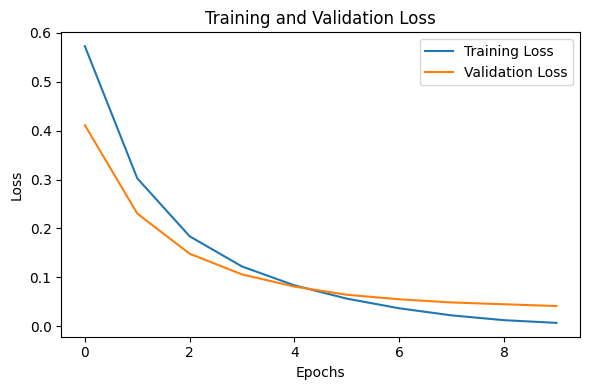

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

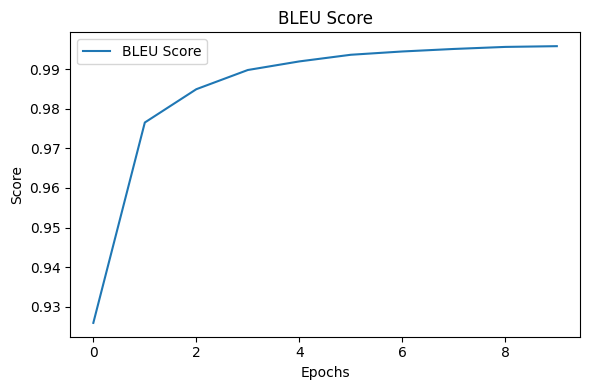

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(bleu_scores, label='BLEU Score')
plt.title('BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()